In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [3]:
df = pd.read_csv('bioactivity_preprocessed_data.csv')

def lipinski(smiles, verbose = False):
    moldata = []
    for elem in smiles:
        mol =  Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData = np.arange(1,1)
    i = 0
    for mol in moldata:
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumAcceptors = Lipinski.NumHAcceptors(mol)

        row = np.array([desc_MolWt,
                       desc_MolLogP,
                       desc_NumHDonors,
                       desc_NumAcceptors])
        if(i==0):
            baseData = row
        else:
            baseData = np.vstack([baseData,row])
        i = i+1

    columnNames = ["MW","LogP","NumHDonors","NumHAcceptors"]
    descriptors = pd.DataFrame(data=baseData, columns = columnNames)

    return descriptors

In [4]:
df_lipinski = lipinski(df.canonical_smiles)
df_combined = pd.concat([df,df_lipinski], axis = 1)

def pAC50(input_df):
    # Convert the normalized values to molar concentration
    input_df['molar'] = input_df['standard_value_norm'] * (10**-9)
    
    # Calculate the pAC50 values
    input_df['pAC50'] = -np.log10(input_df['molar'])
    
    # Drop the intermediate columns
    x = input_df.drop(columns=['standard_value_norm', 'molar'])
    
    return x
# %%
df_combined.standard_value.describe()

count        86.000000
mean      54573.994186
std       94101.084388
min           1.000000
25%       30000.000000
50%       30000.000000
75%       30000.000000
max      500000.000000
Name: standard_value, dtype: float64

In [5]:
def norm_value(input_df):
    # Apply a function to each element in the 'standard_value' column to normalize it
    input_df['standard_value_norm'] = input_df['standard_value'].apply(lambda x: min(x, 100000000))
   
    # Drop the original 'standard_value' column
    x = input_df.drop(columns=['standard_value'])

    return x
# %%
df_norm = norm_value(df_combined)
df_final = pAC50(df_norm)
df_final.pAC50.describe()
df_2class = df_final[df_final.bioactivity_class != 'intermediate']
# %%
# PART TWO
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

Text(0, 0.5, 'Frequency')

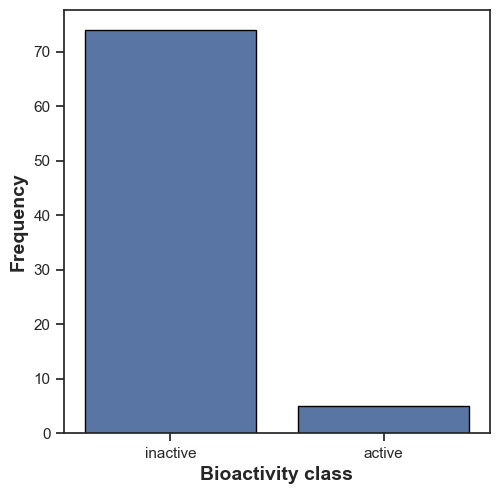

In [6]:
# plotting the graph
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='bioactivity_class', data=df_2class, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

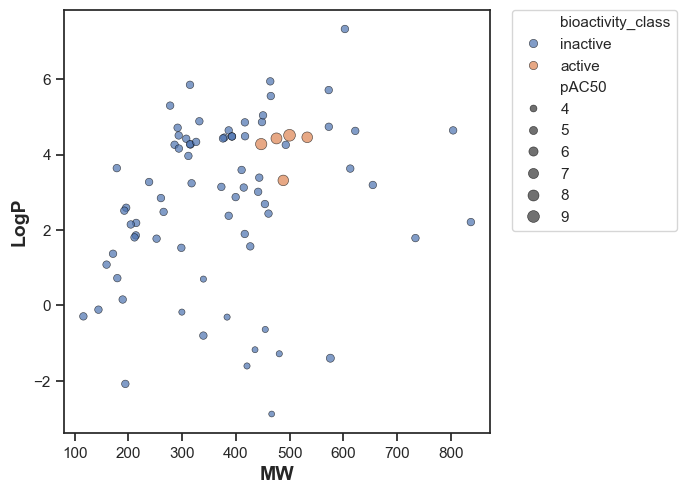

In [7]:
# scatter plotting, MV and LogP
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='bioactivity_class', size='pAC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

Text(0, 0.5, 'pAC50 value')

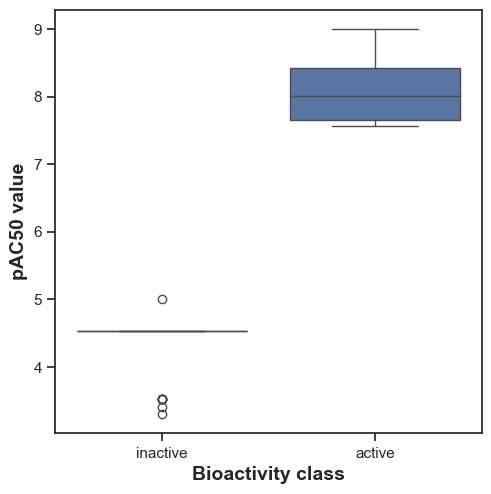

In [8]:
# pAC50 value
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'pAC50', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pAC50 value', fontsize=14, fontweight='bold')

In [9]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  active = df[df.bioactivity_class == 'active']
  active = active[descriptor]

  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  inactive = df[df.bioactivity_class == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])


  return results

Text(0, 0.5, 'MW')

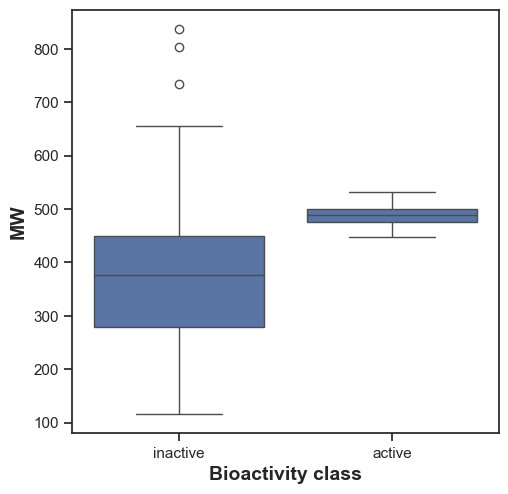

In [10]:
# MW
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

Text(0, 0.5, 'LogP')

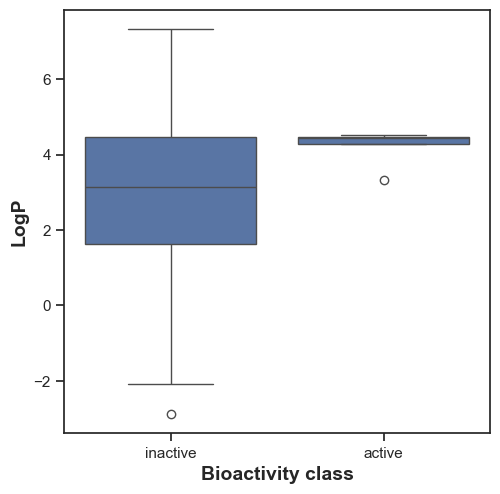

In [11]:
# logP
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'LogP', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

Text(0, 0.5, 'NumHDonors')

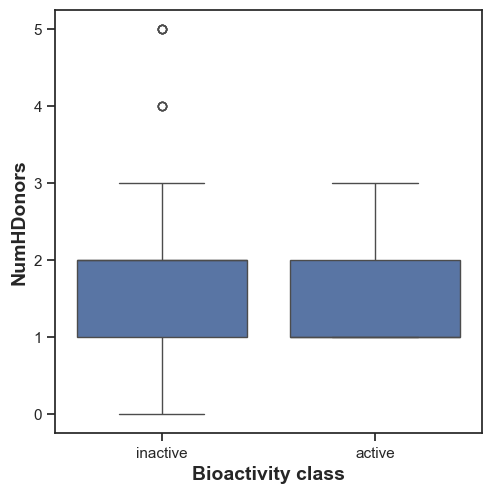

In [12]:
# numhdonors
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHDonors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

Text(0, 0.5, 'NumHAcceptors')

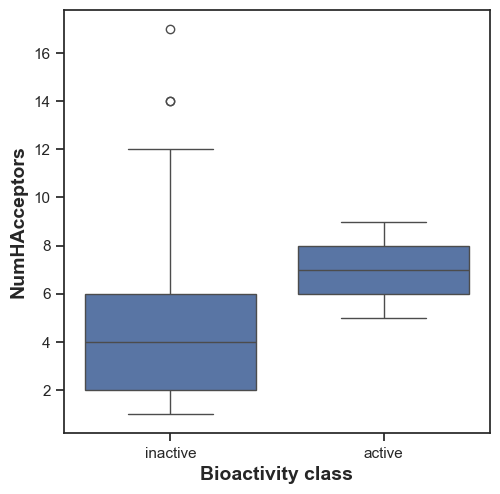

In [13]:
# numhacceptors
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHAcceptors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')